In [28]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import pickle
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

from simulate_data import generate_train_ideal

In [20]:
x_train, xt_train, y_train, x_test, xt_test, y_test = generate_train_ideal()

generating data...


In [21]:
x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

In [25]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

In [26]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

# TRAIN

In [27]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=1843.291260, test_loss=419.025330
iteration=1000, train_loss=92.478256, test_loss=97.354805
iteration=2000, train_loss=46.534706, test_loss=47.283524
iteration=3000, train_loss=18.885002, test_loss=19.809271
iteration=4000, train_loss=8.617194, test_loss=9.475868
iteration=5000, train_loss=4.817916, test_loss=5.193524
iteration=6000, train_loss=3.129249, test_loss=3.440415
iteration=7000, train_loss=2.377301, test_loss=2.603726
iteration=8000, train_loss=1.881568, test_loss=2.102041
iteration=9000, train_loss=1.699257, test_loss=1.914169
iteration=10000, train_loss=2.542636, test_loss=2.703139
iteration=11000, train_loss=2.442232, test_loss=2.419973
iteration=12000, train_loss=1.684646, test_loss=1.734027
iteration=13000, train_loss=0.957029, test_loss=1.106312
iteration=14000, train_loss=0.870045, test_loss=1.014449
iteration=15000, train_loss=0.905709, test_loss=1.050234
iteration=16000, train_loss=1.157810, test_loss=1.220662
iteration=17000, train_loss=0.670

iteration=144000, train_loss=0.002694, test_loss=0.005589
iteration=145000, train_loss=0.002678, test_loss=0.005562
iteration=146000, train_loss=0.002668, test_loss=0.005493
iteration=147000, train_loss=0.002674, test_loss=0.005466
iteration=148000, train_loss=0.002597, test_loss=0.005413
iteration=149000, train_loss=0.002690, test_loss=0.005420
iteration=150000, train_loss=0.003505, test_loss=0.006019
CPU times: user 5min 10s, sys: 1min 34s, total: 6min 45s
Wall time: 6min 9s


In [29]:
file_name = 'LNN_Params'
outfile = open(file_name,'wb')
pickle.dump(params, outfile)
outfile.close()

# Predict

In [32]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t2 = np.linspace(0, 20, num=301)

In [34]:
# predictions from LNN
x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2)) 

In [35]:
# analytical solution
x1_analytical = jax.device_get(solve_analytical(x1, t2))

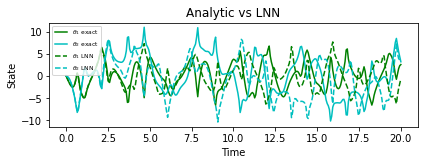

In [36]:
plt.subplot(2,1,2)
plt.title("Analytic vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 2], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 3], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

In [37]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [43]:
# cartesian coordinates for the analytical solution
L1, L2 = 1, 1
theta1_analytic, theta2_analytic = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords_analytical = radial2cartesian(theta1, theta2, L1, L2)

In [45]:
# cartesian coordinates for prediction
theta1_model, theta2_model = x1_model[:, 0], x1_model[:, 1]
cart_coords_model = radial2cartesian(theta1_model, theta2_model, L1, L2)